# PPO and A2C

**Note** : this script is inspired from the 1st assignment (without correction) from the RL course of the MVA master by A. Lazaric and M. Pirotta, on finite MDP and function approximation, which required to complete a partial implementation of A2C for discrete action space. It has been extended to include a different critic and actor architecture, continuous action space, and the clipped and adaptative KL losses required for PPO.

In [1]:
import os
import numpy as np
from pathlib import Path
from pprint import pprint
import itertools
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime

try :
    import Box2D
except :
    !pip install Box2D
import pickle as pkl

import torch
import torch.nn as nn
import torch.nn.functional as F 
from torch import optim
from torch.distributions import normal

import gym
from gym.wrappers import Monitor
from gym.spaces import Box, Discrete

# from pyvirtualdisplay import Display
# from IPython import display as ipythondisplay
# from IPython.display import clear_output
# import base64



######################## Import internal modules 

# import utils

In [2]:
try :
    from google.colab import drive
    drive.mount('/content/drive/')
    %cd /content/drive/My\ Drive/RL-PPO
except :
    print("Script running locally")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/
/content/drive/My Drive/RL-PPO


## Setup the environment
See https://github.com/openai/gym/wiki/Leaderboard for description of OpenAIGym environments

Discrete control settings : 
* "Taxi-v3" : episodic & discrete setting both for states and actions (S/N/E/W/Pickup/Dropoff)
* __"CartPole-v0" / "CartPole-v1" : discrete action and continuous state space__
* __"MountainCar-v0" : discrete action and continuous state space__

Continous control settings :
* __"MountainCarContinuous-v0" (both state and action continuous spaces)__
* "LunarLanderContinuous-v2" (requires box2D)
* "CarRacing-v0" : "Discrete control is reasonable in this environment as well" (requires box2D)

* "MsPacman-v0 "(requires the Atari dependency)

Settings used by the authors (requires the MuJoCo dependencies, 30 days free trial) : https://github.com/openai/mujoco-py
* "HalfCheetah-v1" (use v2 now?)
* "Hopper-v1"
* etc.

## Configuration 

See https://github.com/llSourcell/Unity_ML_Agents/blob/master/docs/best-practices-ppo.md for tuning best practice

In [150]:
def reset_config(print_=False):
    config = {}
#     config['env'] = 'CartPole-v1'
#     config['env'] = 'MountainCarContinuous-v0'
#     config['env'] = 'LunarLander-v2'
    config['env'] = 'MountainCar-v0'

    # config['std'] = 0.5 # use constant standard deviation for continuous action space (for now)
    config['std'] = 0.001 # use constant standard deviation for continuous action space (for now)
    config['gamma'] = 0.99 #Discount rate
    config['lambda'] = 1 # parameter of the generalized advantage estimation
    config['value_network'] = {'lr': 1e-3}
    config['actor_network'] = {'lr': 1e-3}
    config['eps_clipping'] = 0.2 #range : 0.1-0.3
    config['d_targ'] = 0.01
    config['beta_KL'] = 3
    config['c1'] = 1 #paramter of the value function loss
    config['c2'] = 1e-3 #entropy parameter --> 1e-4 to 1e-2
    config['epochs'] = 4
    config['max_episodes'] = 1000
    config['max_steps'] = 300
    config['optimize_every'] = 2000
    config['batch_size'] = 10 #512-5120 for continuous / 32-512 for discrete
    # config['buffer_size'] = 2048 #2048 - 409600 /!\ multiple of the batch size
    config['loss_name'] = ["A2C_loss","adaptative_KL_loss","clipped_loss"][2]
    config['color'] = {"A2C_loss":sns.color_palette("Set2")[0],"adaptative_KL_loss":sns.color_palette("Set2")[1],"clipped_loss":sns.color_palette("Set2")[2]}

    config['seed'] = 1
    config["reset_val"] = None # use to reset the environment with a custom value
    config["solved_reward"] = {'LunarLander-v2':230,
                              'MountainCarContinuous-v0':300,
                              'CartPole-v1':300,
                              'MountainCar-v0':300}
    
    if print_== True :
        print("Training config : \n", config)
    return config

In [151]:
## reset configuration
config = reset_config(print_=True)

Training config : 
 {'env': 'MountainCar-v0', 'std': 0.001, 'gamma': 0.99, 'lambda': 1, 'value_network': {'lr': 0.001}, 'actor_network': {'lr': 0.001}, 'eps_clipping': 0.2, 'd_targ': 0.01, 'beta_KL': 3, 'c1': 1, 'c2': 0.001, 'epochs': 4, 'max_episodes': 1000, 'max_steps': 300, 'optimize_every': 2000, 'batch_size': 10, 'loss_name': 'clipped_loss', 'color': {'A2C_loss': (0.4, 0.7607843137254902, 0.6470588235294118), 'adaptative_KL_loss': (0.9882352941176471, 0.5529411764705883, 0.3843137254901961), 'clipped_loss': (0.5529411764705883, 0.6274509803921569, 0.796078431372549)}, 'seed': 1, 'reset_val': None, 'solved_reward': {'LunarLander-v2': 230, 'MountainCarContinuous-v0': 300, 'CartPole-v1': 300, 'MountainCar-v0': 300}}


In [26]:
## Define environment 
env = gym.make(config['env'])
print(config["env"])
## Save episode
# env = Monitor(env, "./gym-results", force=True)

## Action and state spaces
print("State Space : {}".format(env.observation_space))
if isinstance(env.observation_space, Box) :
    print("continuous state space") 
    print("Lower bound : ", env.observation_space.low)
    print("Upper bound : ", env.observation_space.high)
else :
    print("discrete state space")

print("\nAction Space : {}".format(env.action_space))
if isinstance(env.action_space, Box):
    print("continuous action space") 
    print("Lower bound : ", env.action_space.low)
    print("Uppder bound : ", env.action_space.high)
else :
    print("discrete action space")

print("\nReward range", env.reward_range)
    
## Reset the environment
obs = env.reset()
print("\nInitial state : ",obs)
env = env.env
# env.render()

## Sample randomly one action
action = env.action_space.sample()
print("Sampled action : " , action)

try :
    state, reward, done, info = env.step(a = action)
except :
    state, reward, done, info = env.step(action = action)
# env.render()
print("\nEpisode over : ",done)

MountainCar-v0
State Space : Box(2,)
continuous state space
Lower bound :  [-1.2  -0.07]
Upper bound :  [0.6  0.07]

Action Space : Discrete(3)
discrete action space

Reward range (-inf, inf)

Initial state :  [-0.46757454  0.        ]
Sampled action :  2

Episode over :  False


## Actor and critic networks 


**Note** : 
- these architectures were not defined precisely in the paper 
- no parameter sharing between policy and value function

In [13]:
class CustomValueNetwork(nn.Module):
    """
    Approximation of the value function V of a state given as input
    FC network with 1 hidden layer and ReLU activations
    Class used as 'critic'
    Inputs : 
    input_size : dimension of each state
    hidden_size : number of hidden layers
    output_size : 1 (dimension of the value function estimate)
    """

    def __init__(self, input_size, hidden_size, output_size = 1):
        super(CustomValueNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out = F.relu(self.fc1(x.float()))
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        return out
    
    def predict(self, x):
        return self(x).detach().numpy()[0]

In [0]:
# test 
critic = CustomValueNetwork(env.observation_space.shape[0], 16, 1)
critic(torch.tensor(env.state))

tensor([0.2635], grad_fn=<AddBackward0>)

In [14]:
class CustomDiscreteActorNetwork(nn.Module):
    """
    Custom policy model network for discrete action space
    Inputs : 
    input_size : state space dimension
    hidden_size : nb of hidden layers (64 in author's paper for continous action space)
    action_size : action space dimension
    """
    def __init__(self, input_size, hidden_size, action_size):
        super(CustomDiscreteActorNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, action_size)

    def forward(self, x):
        out = torch.tanh(self.fc1(x))
        out = torch.tanh(self.fc2(out))
        out = torch.tanh(self.fc2(out))
        out = F.softmax(self.fc3(out), dim=-1)
        return out
    
    def select_action(self, x):
        return torch.multinomial(self(x), 1).detach().numpy()

In [15]:
class ContinuousActorNetwork(nn.Module):
    """
    Policy model network for continuous action space (from the paper)
    Inputs : 
    input_size : state space dimension
    hidden_size : nb of hidden layers used by the authors
    action_size : action space dimension
    """
    def __init__(self, input_size, hidden_size, action_size, std, env):
        super(ContinuousActorNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, action_size)
        self.std = std
        self.env = env
        
    def forward(self, x):
        out = torch.tanh(self.fc1(x.float()))
        out = torch.tanh(self.fc2(out))
        out = torch.tanh(self.fc2(out))
        out = torch.tanh(self.fc3(out))
        return out
    
    def select_action(self, x):
#         print(x) #back
        sampled_a = torch.normal(self(x), self.std).detach().numpy()
#         print("sampled a",sampled_a) #back
        sampled_a = max(self.env.action_space.low, sampled_a)
#         print(sampled_a) #back
        sampled_a = min(self.env.action_space.high, sampled_a)
#         print(sampled_a)
        return sampled_a


In [0]:
# test
if isinstance(env.action_space, Discrete) : #check if we are in a discrete action space
    actor = CustomDiscreteActorNetwork(env.observation_space.shape[0], 64, env.action_space.n)
else :
    actor = ContinuousActorNetwork(env.observation_space.shape[0], 64, env.action_space.shape[0], config["std"], env)

print("Mean : ", actor(torch.tensor(env.state)))
print("Sampled action : ", actor.select_action(torch.tensor(env.state)))

Mean :  tensor([0.5120, 0.4880], grad_fn=<SoftmaxBackward>)
Sampled action :  [0]


In [114]:
def plot_result(*df,config,var=["Episode","Reward"]):
    plt.figure(figsize=(8,4))
    for r in df :
        loss_name = r['loss_name'].unique()[0]
        sns.lineplot(x=var[0], y=var[1],  ci='sd', data=r, color=config["color"][loss_name],label=loss_name) 
def plot_sumup(rewards_list,loss_list,config=config):
    plot_result(*rewards_list,config=config)
    plot_result(*loss_list,config=config,var=["Episode","entropy"])
    plot_result(*loss_list,config=config,var=["Episode","dry_loss"])

def plot_sensitivity(*df,config,label_list,var=["Episode","Reward"]):
    plt.figure(figsize=(8,4))
    for i in range(len(label_list)):
        r=df[i]
        col = list(sns.color_palette("Set1")+sns.color_palette("Set3"))[i]
        sns.lineplot(x=var[0], y=var[1],  ci='sd', data=r, 
                     color=col,label=label_list[i])

In [146]:
class PPOAgent:

    def __init__(self, config):
        ## configuration
        self.config = config
        
        ## define environment
        self.env = gym.make(config['env'])
#         print("environment",self.env)
        self.discrete_action_bool = isinstance(self.env.action_space, Discrete)
#         print("Discrete action space : ",self.discrete_action_bool)
        self.gamma = config['gamma'] #discount rate
        self.lambd = config['lambda'] #parameter of the generalized advantage estimation
        self.c1 = config['c1'] # value function hyperparameter
        self.c2 = config['c2'] # entropy bonus hyperparameter (eventually set to 0)
        self.loss_name = config['loss_name'] # loss in ["A2C_loss","adaptative_KL_loss","clipped_loss"]
        self.kl_div = nn.KLDivLoss(reduction="none")
        self.beta_kl = config['beta_KL']
#         self.break_bool = False #make sure the actions are properly defined (no NaN)
        self.reset_val = config["reset_val"]
        if self.discrete_action_bool == False :
            print("Low : ",self.env.action_space.low)
            print("High : ",self.env.action_space.high)
        
        ## set random seeds
        np.random.seed(config['seed'])
        torch.manual_seed(config['seed'])
        self.env.seed(config['seed'])
        
#         # save trajectory
#         self.monitor_env = Monitor(self.env, "./gym-results", force=True, video_callable=lambda episode: True)
        
        
        ## Define actor and critic networks and optimizers
        # Critic
        self.value_network = CustomValueNetwork(self.env.observation_space.shape[0], 16, 1)
        # self.value_network_optimizer: optim.Optimizer = optim.RMSprop(
        self.value_network_optimizer: optim.Optimizer = optim.Adam(
            self.value_network.parameters(), lr=config['value_network']['lr'])
        
        # Actor     
        if self.discrete_action_bool : #check if we are in a discrete action space
            self.actor_network = CustomDiscreteActorNetwork(self.env.observation_space.shape[0], 64, self.env.action_space.n)
        else :
            self.actor_network = ContinuousActorNetwork(self.env.observation_space.shape[0], 64, self.env.action_space.shape[0], self.config["std"], self.env)
        # self.actor_network_optimizer: optim.Optimizer = optim.RMSprop(
        self.actor_network_optimizer: optim.Optimizer = optim.Adam(
            self.actor_network.parameters(), lr=config['actor_network']['lr'])
        
        # save in memory policy estimates
        self.probs_list = []
        self.mean_list = []
        
    def _returns_advantages(self, rewards, dones, values, next_value):
        """Returns the cumulative discounted rewards at each time step

        Parameters
        ----------
        rewards : array
            An array of shape (batch_size,) containing the rewards given by the env
        dones : array
            An array of shape (batch_size,) containing the done bool indicator given by the env
        values : array
            An array of shape (batch_size,) containing the values given by the value network
        next_value : float
            The value of the next state given by the value network
        
        Returns
        -------
        returns : array
            The cumulative discounted rewards
        advantages : array
            The advantages
        """
        returns = 0*torch.tensor(rewards)
        values = torch.tensor(values)
        
        R = next_value
        for i in range(1, len(rewards)+1):
            retro_prop = 1-dones[-i]  # whether to use the following value
            R = rewards[-i] + (self.lambd*self.gamma * retro_prop * R)
            returns[-i] = R
        
        advantages = returns - values
        return returns, advantages

    def training(self, epochs, optimize_every, max_episodes, max_steps):
        t1 = datetime.datetime.now()
        """Perform a training by batch

        Parameters
        ----------
        epochs : int
            Number of epochs
        batch_size : int
            The size of a batch
        """
        episode_count = 0
        timestep_count = 0
        actions = []
        dones = []
        rewards, values = [], []
        returns, advantages = [], []
        observations = []    
        rewards_test = []
        loss_evol = {'loss':[],'dry_loss':[],'entropy':[]}
        if self.loss_name not in ["A2C_loss","adaptative_KL_loss","clipped_loss"]:
            print('Unknown loss function, using clipped loss as default loss')
        else :
            print('Loss : ',self.loss_name)
        
        for ep in range(max_episodes):
            episode_count +=1
#             assert self.break_bool == False
            obs = self.env.reset()
            ## added : special initialization
            if self.reset_val is not None:
                self.env.env.state = np.array(self.reset_val)
                obs = self.env.env.state
                
            
            for i in range(max_steps):
                timestep_count +=1 
                observations.append(obs)  # just observed s_t
                obs_t = torch.from_numpy(obs).float()  # tensor
                action = self.actor_network.select_action(obs_t)  # act on just observed, action a_t
                
                if self.discrete_action_bool : #convert to integer only for discrete action space
                    action = int(action)
                actions.append(action)
  
                # value function estimate of s_t
                values.append(self.value_network(obs_t))
                
                ## Run a step : get new state s_{t+1} and rewards r_t
                obs, reward, done, _ = self.env.step(action) 
                
                # Store termination status reward
                dones.append(done)
                rewards.append(reward)
                 
                if (timestep_count % optimize_every) == 0 :
                     # Learning step !
                     # If our episode didn't end on the last step we need to compute the value for the last state
                    if dones[-1]:
                        next_value = 0  # no value function adjustment
                    else:
                        obs_t = torch.from_numpy(observations[-1]).float()
                        next_value = self.value_network.predict(obs_t)

                     # Compute returns and advantages
                    returns_, advantages_ = self._returns_advantages(rewards, dones, values, next_value)
                    returns.append(returns_)
                    advantages.append(advantages_)

                
                    ##TODO : see what to keep
                    for epoch in range(epochs):
                        loss_val, dry_loss_val, entrop_val = self.optimize_model(observations, actions, returns, dones, advantages)
                        # only save result of last epoch
                        if epoch == epochs-1 :
                            loss_evol["loss"].append(loss_val)
                            loss_evol["dry_loss"].append(dry_loss_val)
                            loss_evol["entropy"].append(entrop_val)
                    # reset ??TOCHECK
                    actions = []
                    dones = []
                    rewards, values = [], []
                    returns, advantages = [], []
                    observations = []    
                
                # reset the environment if last observation is the a terminal state
                if done:
                    break 
#                     obs = self.env.reset()
#                     ## added
#                     if self.reset_val is not None:
#                         self.env.env.state = np.array(self.reset_val)
#                         obs = self.env.env.state


            
#             # Update episode_count
#             episode_count += sum(dones)

           
           
            
            # Test it every 25 epochs
            if ep == 1 or (ep > 0 and ep % 25 == 0) or (ep == max_episodes - 1):
                rewards_test.append(np.array([self.evaluate() for _ in range(50)]))
                print(f'Episode {ep}/{max_episodes}: Mean rewards: {round(rewards_test[-1].mean(), 2)}, Std: {round(rewards_test[-1].std(), 2)}')
#                 #+++ Early stopping ++ to add --> which condition ??
            
#             obs = self.env.reset()
#             ## added : special initialization
#             if self.reset_val is not None:
#                 self.env.env.state = np.array(self.reset_val)
#                 obs = self.env.env.state
                
        self.env.close()
        t2 = datetime.datetime.now()
        
        # save rewards
        r = pd.DataFrame((itertools.chain(*(itertools.product([i], rewards_test[i]) for i in range(len(rewards_test))))), columns=['Episode', 'Reward'])
        r["Episode"] = r["Episode"]*25
        r["loss_name"] = self.loss_name # add loss name as label
        
#         # Plot
#         sns.lineplot(x="Epoch", y="Reward", data=r, ci='sd',color=config["color"][self.loss_name],label=self.loss_name)
        
        # Total time ellapsed
        time = t2-t1
        print(f'The training was done over a total of {episode_count} episodes')
        print('Total time ellapsed during training : ',time)
        r["time"]=time
        loss_evol = pd.DataFrame(loss_evol).astype(float)
        loss_evol["loss_name"] = self.loss_name
        loss_evol["Episode"] = np.array(range(len(loss_evol)))*25
        return r, loss_evol
        
        
    def A2C_loss(self, prob, actions, advantages):
        loss = 0.
        if self.discrete_action_bool :
            for i in range(len(actions)):
                loss -= torch.log(prob[i, int(actions[i])])*advantages[i]
        else :
            loss = torch.dot(torch.log(prob.view(-1)),advantages)      
        return loss
    
    def compute_proba_ratio(self, prob, actions):
        #1st iteration : initialize old policy to the current one to avoid clipping
        if len(self.probs_list) == 1:
            old_prob = self.probs_list[0]
        else :
            old_prob = self.probs_list[len(self.probs_list)-2]
            
        # Discrete action space
        if self.discrete_action_bool :
            # compute the ratio directly using gather function
            num = prob.gather(1, actions.long().view(-1,1))
#             print(num.size())
#             print(actions.long().view(-1,1).size())
#             print(old_prob.size())
            denom = old_prob.detach().gather(1, actions.long().view(-1,1))
            ratio_vect = num.view(-1)/denom.view(-1)
        
        # Continuous action space
        else :##+++ add small constant to avoid ratio explosion ? consider clipping enough ?? 
            ratio_vect = prob.view(-1)/old_prob.view(-1)
        
        if np.isnan(ratio_vect.detach().numpy()).any():
            print("NaN encountered in proba ratio")

        return ratio_vect, old_prob
    
    def clipped_loss(self, prob, actions, advantages):##++TODO
        ##Compute the probability ratio
        ratio_vect = self.compute_proba_ratio(prob, actions)[0]
        ## Compute the loss
        loss1 = ratio_vect * advantages
        loss2 = torch.clamp(ratio_vect, 1-self.config['eps_clipping'], 1+self.config['eps_clipping']) * advantages
        loss = - torch.sum(torch.min(loss1, loss2))/self.config["batch_size"]
        return loss

    def adaptative_KL_loss(self, prob, actions, advantages, observations):
        ## Compute the loss
        if self.discrete_action_bool :
            ##Compute the probability ratio
            ratio_vect, old_prob = self.compute_proba_ratio(prob, actions)
            kl = self.kl_div(prob[observations.long(),:], old_prob[observations.long(),:])
            kl = kl.view(prob.size()[0],-1).mean(1)
        else :
            ratio_vect = self.compute_proba_ratio(prob, actions)[0]
            if len(self.mean_list) == 1:
                kl = torch.tensor(0.)
            else :
                mu = prob.view(-1)
                mu_old = self.mean_list[len(self.mean_list)-2].view(-1).detach()
                # use KL formula for gaussian 
                kl = torch.dot((mu-mu_old)/torch.tensor(config["std"]*np.ones(len(actions))).float(),mu-mu_old)/2
                
        loss = - torch.sum((ratio_vect*advantages) - (self.beta_kl*kl))/self.config["batch_size"]
        # Update beta values
        if np.isnan(torch.mean(kl).detach().numpy()):
            print("Nan encountered in average KL divergence")
        if torch.mean(kl) < self.config["d_targ"]/1.5 : 
            self.beta_kl = self.beta_kl / 2
        elif torch.mean(kl) > self.config["d_targ"]*1.5 :
            self.beta_kl = self.beta_kl * 2
        return loss
    
    
        
    def optimize_model(self, observations, actions, returns, dones, advantages):
        
        n_trajs = np.sum(dones)
#         print(type(observations))
#         print(type(actions))
#         print(type(returns))
#         print(type(advantages))
        
        observations = torch.tensor(observations).float()
        actions = torch.tensor(actions).float()
        returns = returns[len(returns)-1].float()
        advantages = advantages[len(advantages)-1].float()
    
        # Critic loss
        net_values: torch.Tensor = self.value_network(observations)
        critic_loss = F.mse_loss(net_values.view(-1), returns)
        critic_loss.backward()
        
        self.value_network_optimizer.step()
        
        # Actor & Entropy loss
        #/!\ doesn't have the same meaning in the discrete and continuous case
        prob: torch.Tensor = self.actor_network(observations)  # shape (batch_size,action_space)
        
        
        if self.discrete_action_bool == True :
            self.probs_list.append(prob.detach())
        else :#there
            print("act2",type(actions))
            m = normal.Normal(loc = prob.view(-1).float(), scale = torch.tensor(config["std"]*np.ones(len(actions))).float())
            logprob = m.log_prob(torch.tensor(actions).float())
            # /!\ to add for truncated version :
#             logprob_bound = m.log_prob(torch.tensor(self.env.action_space.high))
#             self.probs_list.append(torch.max(torch.zeros_like(logprob),torch.exp(logprob).detach()-torch.exp(logprob_bound).detach()))
            # /!\ non truncated version :
            self.probs_list.append(torch.exp(logprob).detach())
            self.mean_list.append(prob)
        
        if not dones[-1]:
            n_trajs += 1
        
        if self.loss_name == "clipped_loss":
            loss = self.clipped_loss(prob, actions, advantages)

        elif self.loss_name == "adaptative_KL_loss":
            loss = self.adaptative_KL_loss(prob, actions, advantages, observations)
            
        elif self.loss_name == "A2C_loss":
            loss = self.A2C_loss(prob, actions, advantages)
            
        else :#use clipped loss as default
            loss = self.clipped_loss(prob, actions, advantages)
            
        dry_loss = loss 
        entropy_term = -torch.sum(prob * torch.log(prob))
        loss -= (self.c2 * entropy_term)
        loss = loss / n_trajs
        
        loss.backward()
        
        self.actor_network_optimizer.step()
        
        self.value_network_optimizer.zero_grad()
        self.actor_network_optimizer.zero_grad()

        return loss.detach().numpy(), dry_loss.detach().numpy(), entropy_term.detach().numpy()

    def evaluate(self, render=False):
        env = self.monitor_env if render else self.env
        observation = env.reset()
        ## added : special initialization
        if self.reset_val is not None:
            self.env.env.state = np.array(self.reset_val)
            observation = self.env.env.state
        observation = torch.from_numpy(observation).float()
        reward_episode = 0
        done = False
        with torch.no_grad():
            while not done:
                policy = self.actor_network(observation)
                
                ##++ question : why not only sample action ?? 
                if self.discrete_action_bool : 
                    action = int(torch.multinomial(policy, 1))  # draw an action
                else :
                    action = self.actor_network.select_action(observation)
                observation, reward, done, info = env.step(action)
                observation = torch.from_numpy(observation).float()
                reward_episode += reward
            
        env.close()
        if render:
            show_video("./gym-results")
            print(f'Reward: {reward_episode}')
        return reward_episode

In [ ]:
config["env"] = 'LunarLander-v2'
rewards_list = []
loss_list = []
for loss in ["clipped_loss","adaptative_KL_loss","A2C_loss"]:
    print("-----------------"+loss+"-----------------")
    config["loss_name"]=loss
    print(config)
    agent = PPOAgent(config)
    
    rewards, loss = agent.training(config["epochs"], config["optimize_every"], config["max_episodes"], config["max_steps"])
    rewards_list.append(rewards)
    loss_list.append(loss)

In [147]:
config["env"] = 'CartPole-v1'
rewards_list = []
loss_list = []
for loss in ["clipped_loss","adaptative_KL_loss","A2C_loss"]:
    print("-----------------"+loss+"-----------------")
    config["loss_name"]=loss
    print(config)
    agent = PPOAgent(config)
    
    rewards, loss = agent.training(config["epochs"], config["optimize_every"], config["max_episodes"], config["max_steps"])
    rewards_list.append(rewards)
    loss_list.append(loss)

-----------------clipped_loss-----------------
{'env': 'CartPole-v1', 'std': 0.001, 'gamma': 0.99, 'lambda': 1, 'value_network': {'lr': 0.001}, 'actor_network': {'lr': 0.001}, 'eps_clipping': 0.2, 'd_targ': 0.01, 'beta_KL': 3, 'c1': 1, 'c2': 0.001, 'epochs': 4, 'batch_size': 100, 'loss_name': 'clipped_loss', 'color': {'A2C_loss': (0.4, 0.7607843137254902, 0.6470588235294118), 'adaptative_KL_loss': (0.9882352941176471, 0.5529411764705883, 0.3843137254901961), 'clipped_loss': (0.5529411764705883, 0.6274509803921569, 0.796078431372549)}, 'seed': 1, 'reset_val': None, 'solved_reward': {'LunarLander-v2': 230, 'MountainCarContinuous-v0': 300, 'CartPole-v1': 300, 'MountainCar-v0': 300}, 'max_episodes': 1000, 'max_steps': 300, 'optimize_every': 2000}
Loss :  clipped_loss
Episode 1/1000: Mean rewards: 24.28, Std: 12.39
Episode 25/1000: Mean rewards: 21.28, Std: 9.0
Episode 50/1000: Mean rewards: 24.3, Std: 12.73
Episode 75/1000: Mean rewards: 22.08, Std: 8.04
Episode 100/1000: Mean rewards: 24.

Episode 800/1000: Mean rewards: 483.66, Std: 67.45
Episode 825/1000: Mean rewards: 456.92, Std: 109.53
Episode 850/1000: Mean rewards: 472.06, Std: 72.32
Episode 875/1000: Mean rewards: 474.2, Std: 74.26
Episode 900/1000: Mean rewards: 459.68, Std: 46.23
Episode 925/1000: Mean rewards: 463.98, Std: 50.05
Episode 950/1000: Mean rewards: 463.78, Std: 37.08
Episode 975/1000: Mean rewards: 494.14, Std: 13.86
Episode 999/1000: Mean rewards: 499.48, Std: 3.12
The training was done over a total of 1000 episodes
Total time ellapsed during training :  0:10:00.507190


Pickle name :  6762380
Configuration :  {'env': 'CartPole-v1', 'std': 0.001, 'gamma': 0.99, 'lambda': 1, 'value_network': {'lr': 0.001}, 'actor_network': {'lr': 0.001}, 'eps_clipping': 0.2, 'd_targ': 0.01, 'beta_KL': 3, 'c1': 1, 'c2': 0.001, 'epochs': 4, 'batch_size': 100, 'loss_name': 'A2C_loss', 'color': {'A2C_loss': (0.4, 0.7607843137254902, 0.6470588235294118), 'adaptative_KL_loss': (0.9882352941176471, 0.5529411764705883, 0.3843137254901961), 'clipped_loss': (0.5529411764705883, 0.6274509803921569, 0.796078431372549)}, 'seed': 1, 'reset_val': None, 'solved_reward': {'LunarLander-v2': 230, 'MountainCarContinuous-v0': 300, 'CartPole-v1': 300, 'MountainCar-v0': 300}, 'max_episodes': 1000, 'max_steps': 300, 'optimize_every': 2000}


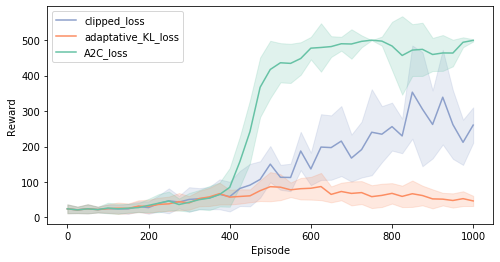

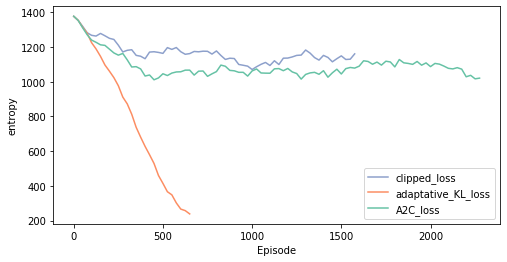

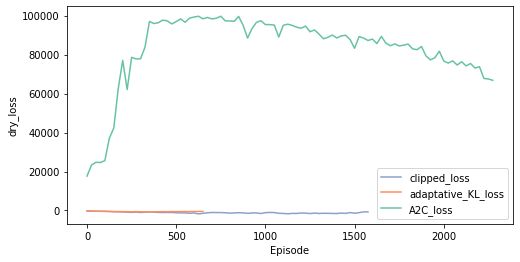

In [149]:
plot_sumup(rewards_list,loss_list,config=config)
name = str(np.random.randint(0,1e8))
print("Pickle name : ",name)
print("Configuration : ",config)
pkl.dump({"config":config,"loss":loss_list,"rewards":rewards_list},open("pickles/"+name+".pkl","wb"))
# res = pkl.load(open("pickles/"+name+".pkl","rb"))

### Clipped PPO - Sensitivity analysis

In [153]:
reset_config()
config["env"] = 'CartPole-v1'
rewards_list = []
loss_list = []
config["loss_name"]="clipped_loss"
print("-----------------"+config["loss_name"]+"-----------------")
eps_list = [0.1,0.15,0.2,0.25,0.3,0.5,0.8]
for eps in eps_list:
    print("--------eps=",eps)
    config['eps_clipping'] = eps
    print(config)
    agent = PPOAgent(config)
    config["epochs"] = 1000
    config["batch_size"] = 100
    rewards, loss = agent.training(config["epochs"], config["optimize_every"], config["max_episodes"], config["max_steps"])
    rewards_list.append(rewards)
    loss_list.append(loss)

In [152]:
plot_sensitivity(*rewards_list,config=config,label_list=eps_list,var=["Epoch","Reward"])
plot_sensitivity(*loss_list,config=config,label_list=eps_list,var=["Epoch","entropy"])
plot_sensitivity(*loss_list,config=config,label_list=eps_list,var=["Epoch","dry_loss"])

name = str(int(datetime.datetime.now().timestamp()))
print("Sensitivity list : ",eps_list)
print("Pickle name : ",name)
print("Configuration : ",config)
pkl.dump({"config":config,"loss":loss_list,"rewards":rewards_list},open("pickles/"+name+".pkl","wb"))

### Adaptative KL - sensitivity analysis

In [156]:
reset_config()
config["env"] = 'CartPole-v1'
rewards_list = []
loss_list = []
config["loss_name"]="adaptative_KL_loss"
print("-----------------"+config["loss_name"]+"-----------------")
beta_list = [1e-1,1,2,2.5,3,3.5,4,5,10,100]
for beta in beta_list:
    config['beta_KL'] = beta
    print('------------beta=',beta)
    print(config)
    agent = PPOAgent(config)
    rewards, loss = agent.training(config["epochs"], config["optimize_every"], config["max_episodes"], config["max_steps"])
    rewards_list.append(rewards)
    loss_list.append(loss)

In [157]:
plot_sensitivity(*rewards_list,config=config,label_list=beta_list,var=["Epoch","Reward"])
plot_sensitivity(*loss_list,config=config,label_list=beta_list,var=["Epoch","entropy"])
plot_sensitivity(*loss_list,config=config,label_list=beta_list,var=["Epoch","dry_loss"])

name = str(int(datetime.datetime.now().timestamp()))
print("Sensitivity list : ",beta_list)
print("Pickle name : ",name)
print("Configuration : ",config)
pkl.dump({"config":config,"loss":loss_list,"rewards":rewards_list},open("pickles/"+name+".pkl","wb"))
# res = pkl.load(open("pickles/"+name+".pkl","rb"))